In [1]:
# -*- coding: utf-8 -*-
from glob import glob
import xml.etree.ElementTree as ET
import tensorflow as tf
from object_detection.utils import dataset_util
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from __future__ import unicode_literals
import matplotlib
from matplotlib.font_manager import FontProperties
import matplotlib as mpl
import codecs
import hashlib
import json
import io
import PIL.Image

# Attempt to initialize xml file names and tensorflow flags

In [2]:
flags = tf.app.flags
flags.DEFINE_string('output_path', '/tmp/tfrecords/thesis', 'Path to output TFRecord')
FLAGS = flags.FLAGS
mpl.rcParams['figure.dpi']= 250
zh_font = FontProperties(fname = '/usr/share/fonts/opentype/noto/NotoSerifCJK-Regular.ttc')

# This number is the lowest allowed number of samples
min_train = 70

In [3]:
with open('annotations.json', 'r') as f:
            annotations = json.load(f)

In [4]:
target_names = []
num_imgs = 0


for img in annotations:
    num_imgs += 1
    img_name = img['label']
    target_names.append(img_name)


# Show some statistics
Save labels to a file

In [5]:
labels, values = zip(*Counter(target_names).items())
indexes = np.arange(len(labels))

plt.bar(indexes, values, 1)
plt.xticks(indexes, labels, rotation=90) # fontproperties = zh_font)
plt.savefig('data_1211.png',  bbox_inches='tight')

# This portion creates the label map file

In [6]:
saved_dict = dict()
reverse_dict = dict()
with codecs.open('auto_annotation_label_map.pbtxt', 'w', encoding='utf8') as f:
    counter = 1
    for iii in range(len(labels)):
        if values[iii] < min_train :
            continue
        saved_dict[labels[iii]] = counter
        reverse_dict[counter] = labels[iii]
        f.write(u'item {\n')
        f.write(u'\tid: {}\n'.format(counter))
        f.write(u"\tname: '{}'\n".format(labels[iii]))
        f.write(u'}\n\n')
        counter+=1

# Defining now the main conversion function

In [22]:
def create_tf_example(example):
  # TODO(user): Populate the following variables from your example.
  # DONE
  # Process one image data per run

  height = int(example['height']) # Image height
  width = int(example['width']) # Image width
  filename = example['path'].encode('utf8')# Filename of the image. Empty if image is not from file
  encoded_image_data = None # Encoded image bytes
  with tf.gfile.GFile(filename,'rb') as fid:
    encoded_jpg = fid.read()

  encoded_jpg_io = io.BytesIO(encoded_jpg)
  image = PIL.Image.open(encoded_jpg_io)
  key = hashlib.sha256(encoded_jpg).hexdigest()

  image_format = 'jpeg'.encode('utf8') # b'jpeg' or b'png'

  xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
  xmaxs = [] # List of normalized right x coordinates in bounding box
             # (1 per box)
  ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
  ymaxs = [] # List of normalized bottom y coordinates in bounding box
             # (1 per box)
  classes_text = [] # List of string class name of bounding box (1 per box)
  classes = [] # List of integer class id of bounding box (1 per box)
    
  # Loop oer the boxes and fill the above fields
#   for box in example:
    
#     box_name = ''
#     for attr in box:
#         if attr.attrib['name'] == u'brand牌':
  bbox = \
        np.array([float(example['tlx']), float(example['tly']), float(example['brx']), float(example['bry'])])
  bbox[bbox<0] = 0
  
  
  xmins.append(bbox[0] / 54)
  xmaxs.append(bbox[2] / 54)
  ymins.append(bbox[1] / 54)
  ymaxs.append(bbox[3] / 54)
  classes_text.append(example['label'].encode('utf8'))
  classes.append(saved_dict[example['label']])

  tf_example = tf.train.Example(features=tf.train.Features(feature={
      'image/height': dataset_util.int64_feature(height),
      'image/width': dataset_util.int64_feature(width),
      'image/filename': dataset_util.bytes_feature(filename),
      'image/source_id': dataset_util.bytes_feature(filename),
      'image/key/sha256': dataset_util.bytes_feature(key.encode('utf8')),
      'image/encoded': dataset_util.bytes_feature(encoded_jpg),
      'image/format': dataset_util.bytes_feature(image_format),
      'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
      'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
      'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
      'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
      'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
      'image/object/class/label': dataset_util.int64_list_feature(classes),
  }))
  return tf_example


def main():
  print(num_imgs)
  num_iter = num_imgs
  eval_num = num_iter // 10
  train_num = num_iter - eval_num

  writer_train = tf.python_io.TFRecordWriter('/tmp/tfrecords/MSTAR_2_train')
  writer_eval = tf.python_io.TFRecordWriter('/tmp/tfrecords/MSTAR_2_eval')
  # TODO(user): Write code to read in your dataset to examples variable DONE
  for counter,example in enumerate(annotations):
    tf_example = create_tf_example(example)
    if(counter < train_num):
        writer_train.write(tf_example.SerializeToString())
    else :
        writer_eval.write(tf_example.SerializeToString())

  writer_train.close()
  writer_eval.close()


main()

5898


# test some random boxes # 

[17 15 32 32]
[17 15 32 32]
[13  9 44 44]
[13  9 44 44]
[ 7  9 52 52]
[ 20  26 152 152]
[19 19 44 44]
[ 55  55 128 128]
[ 9 15 42 42]
[ 21  35 100 100]
[19 17 40 40]
[19 17 40 40]
[15  1 48 48]
[15  1 48 48]
[ 5  9 46 46]
[ 14  26 134 134]
[19 19 34 34]
[19 19 34 34]
[15 13 36 36]
[15 13 36 36]
[13 11 38 38]
[13 11 38 38]
[17 15 40 40]
[17 15 40 40]
[21  3 38 38]
[21  3 38 38]
[17 23 38 38]
[ 49  67 111 111]
[ 9 19 38 38]
[21 45 90 90]
[15  5 34 34]
[43 14 99 99]
[ 7 17 44 44]
[ 16  40 105 105]
[ 7  5 44 44]
[ 20  14 128 128]
[19 13 34 34]
[55 38 99 99]
[ 7  5 46 46]
[ 20  14 134 134]
[ 5  9 36 36]
[11 21 86 86]
[21  1 38 38]
[50  2 90 90]
[17  0 40 40]
[17  0 40 40]
[11  9 42 42]
[11  9 42 42]
[21 19 36 36]
[21 19 36 36]
[ 9  9 36 36]
[ 26  26 105 105]
[11 19 46 46]
[ 32  55 134 134]
[19  0 38 38]
[19  0 38 38]
[ 5  5 48 48]
[ 14  14 140 140]
[ 7 19 34 34]
[16 45 81 81]


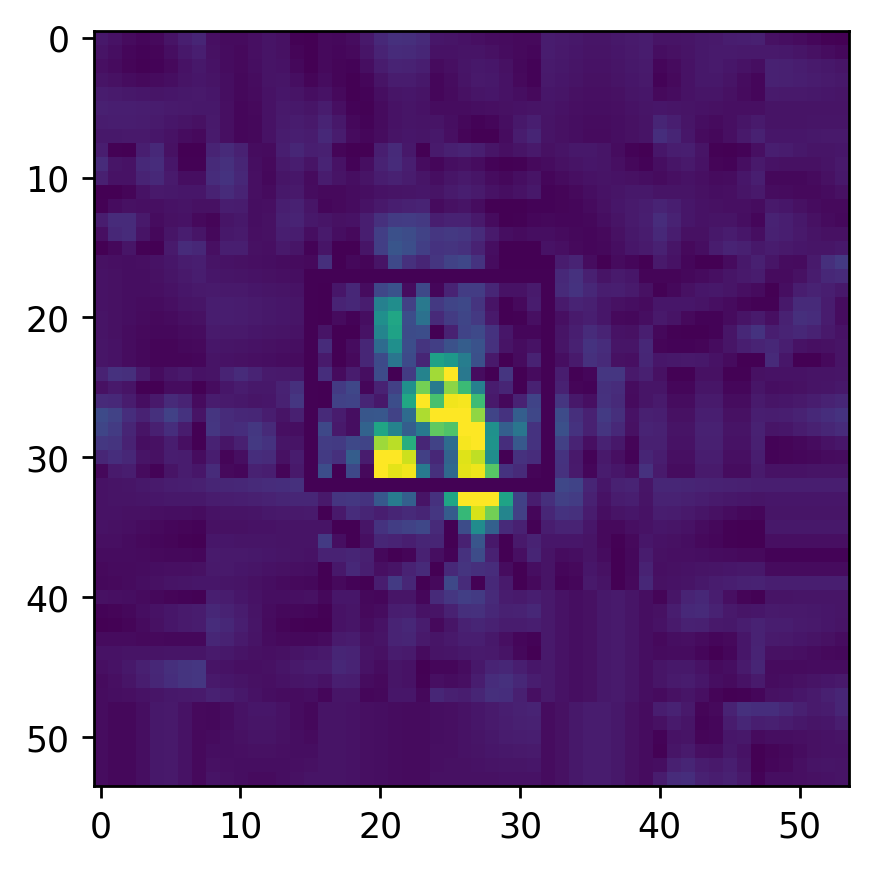

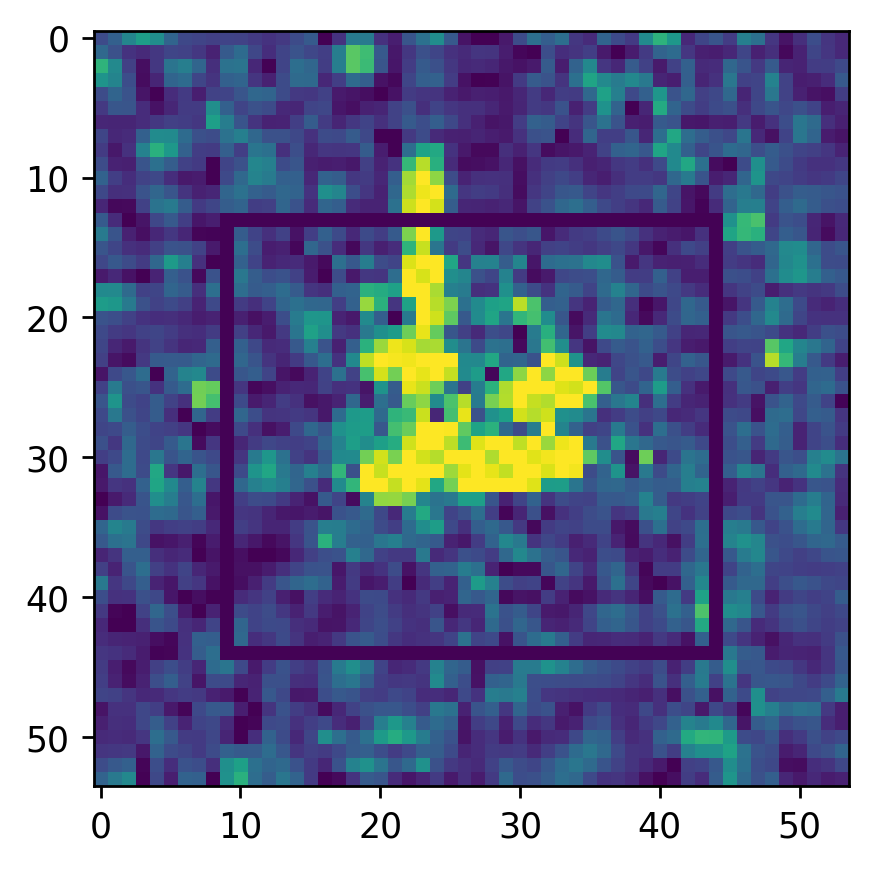

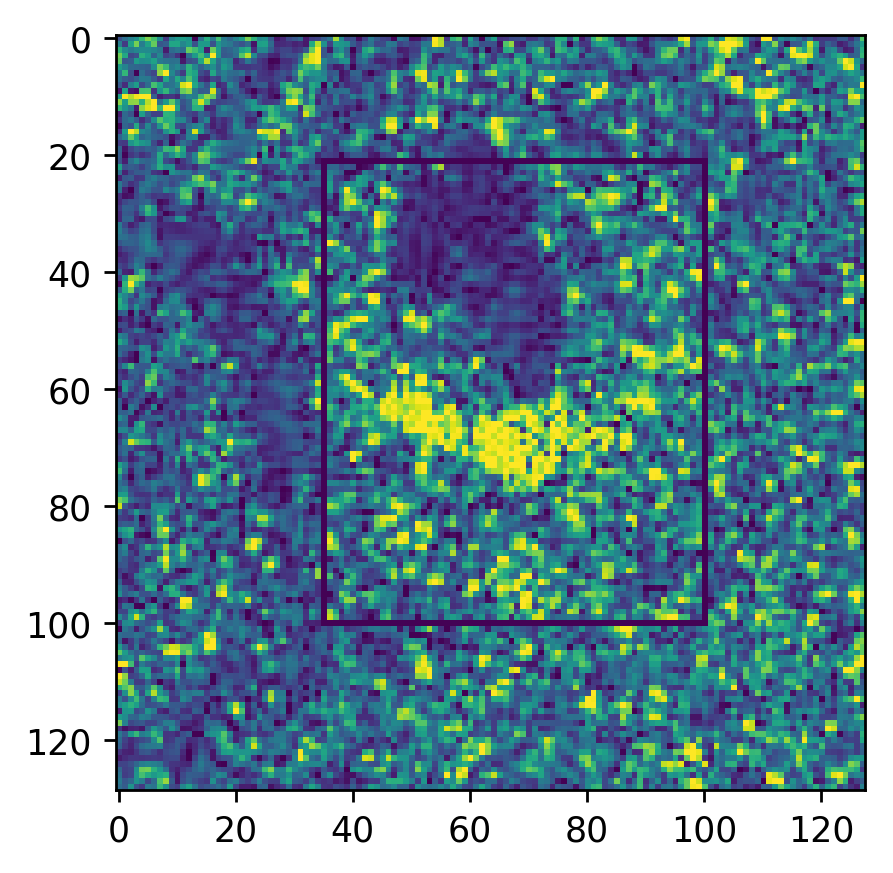

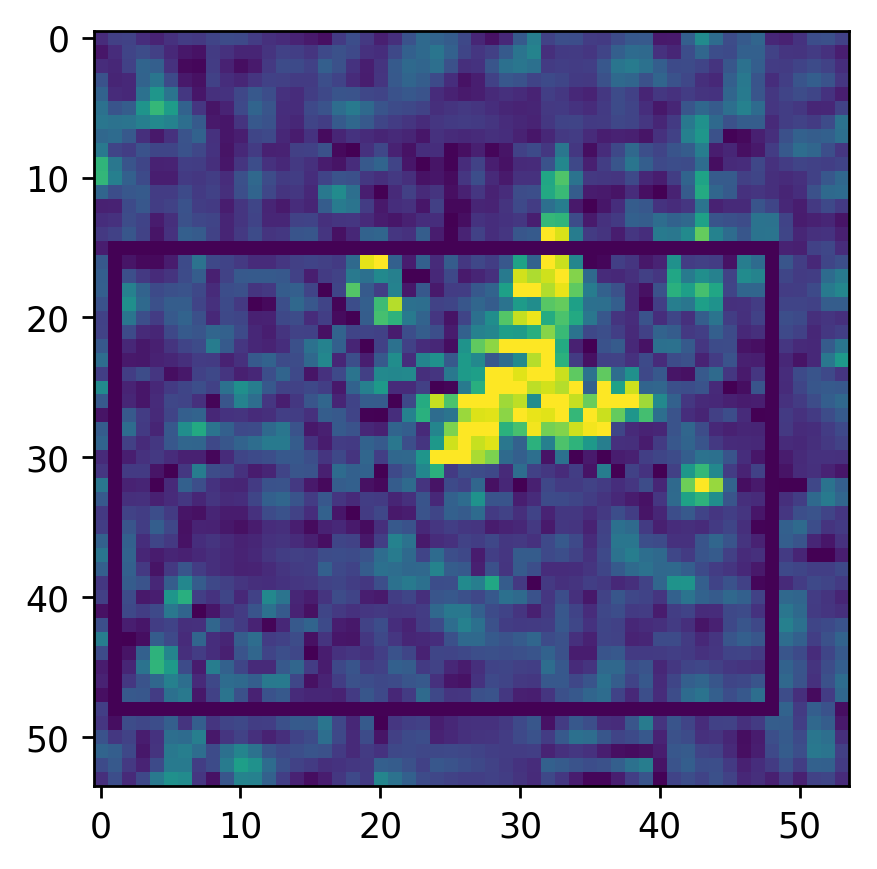

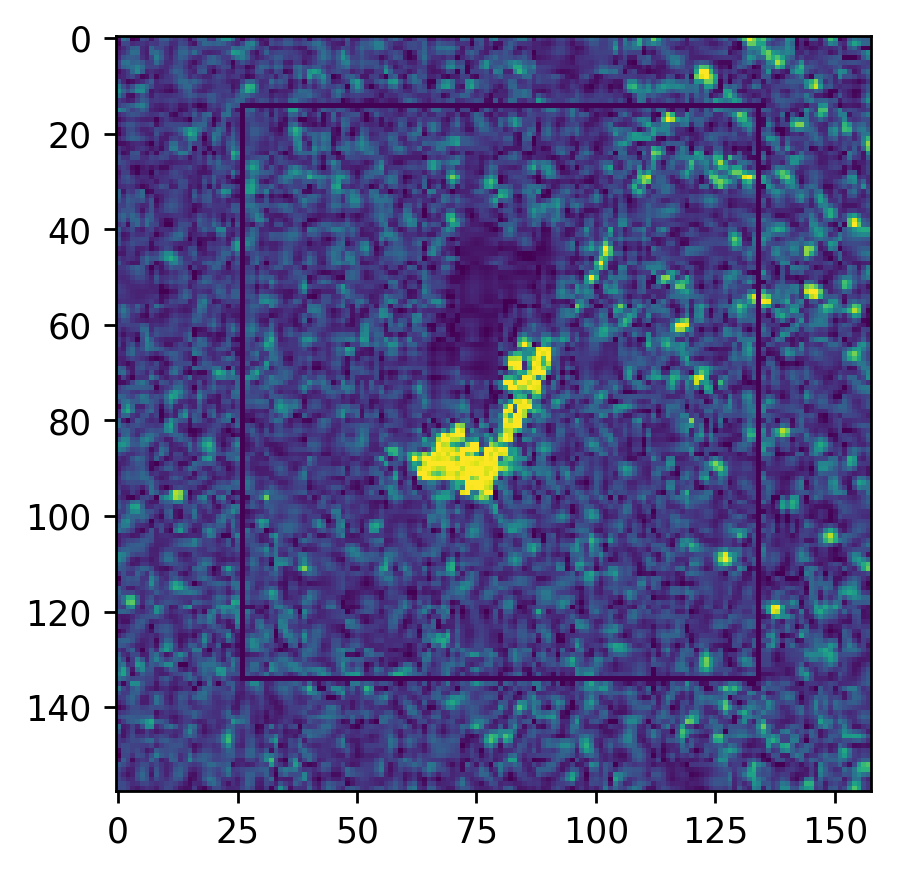

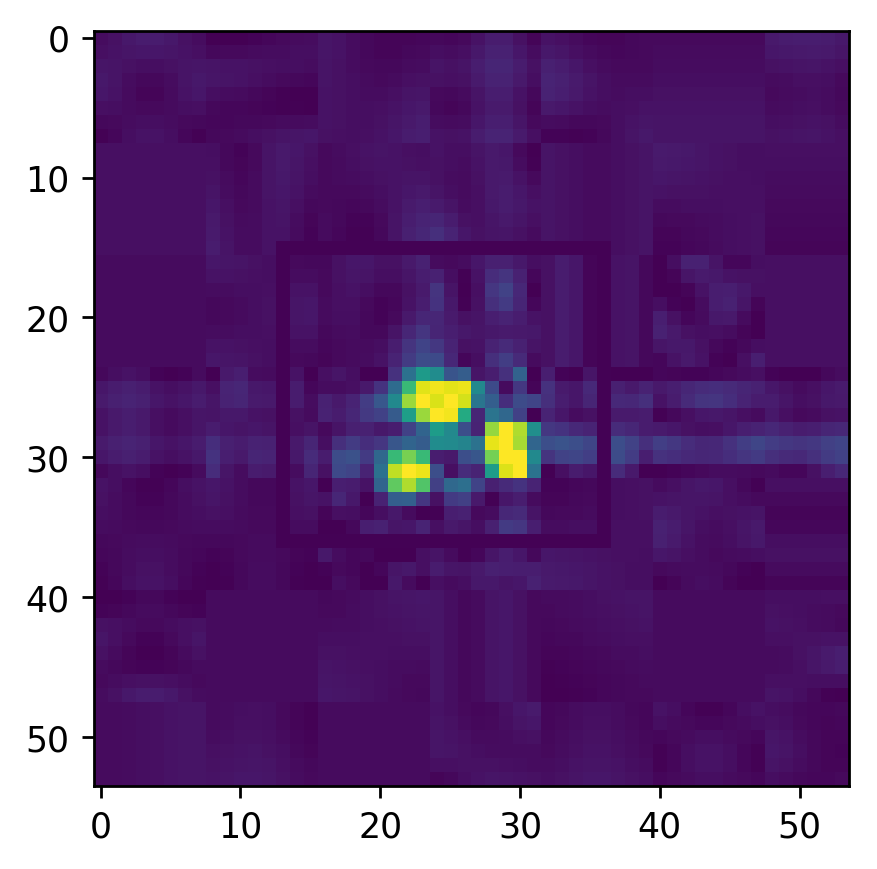

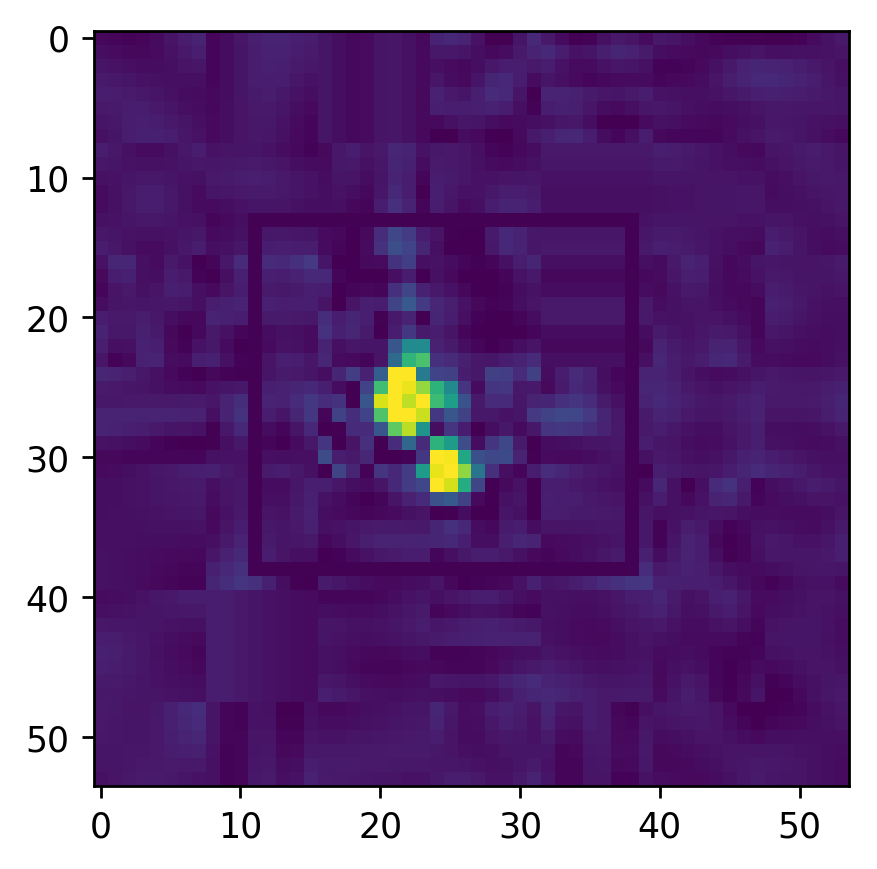

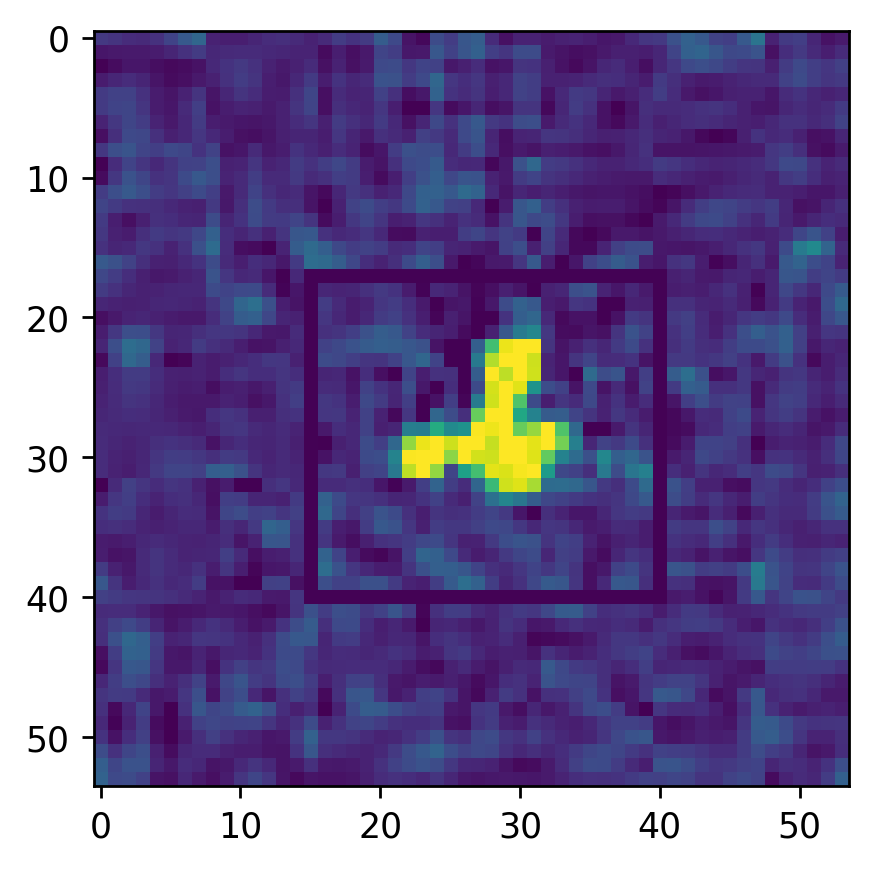

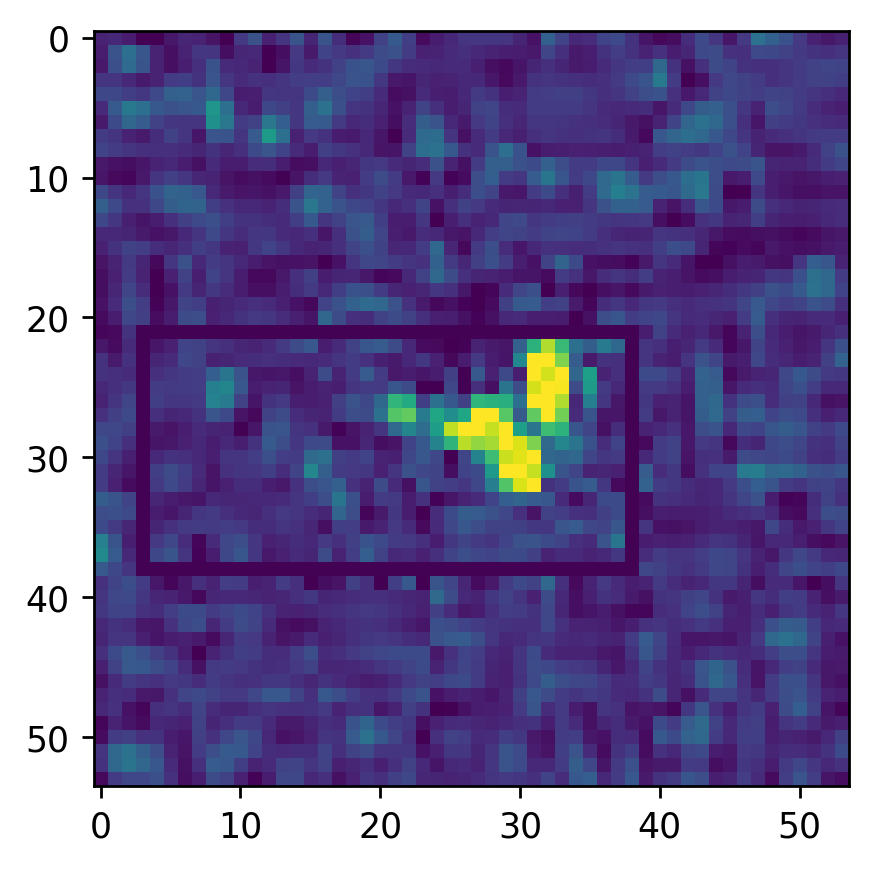

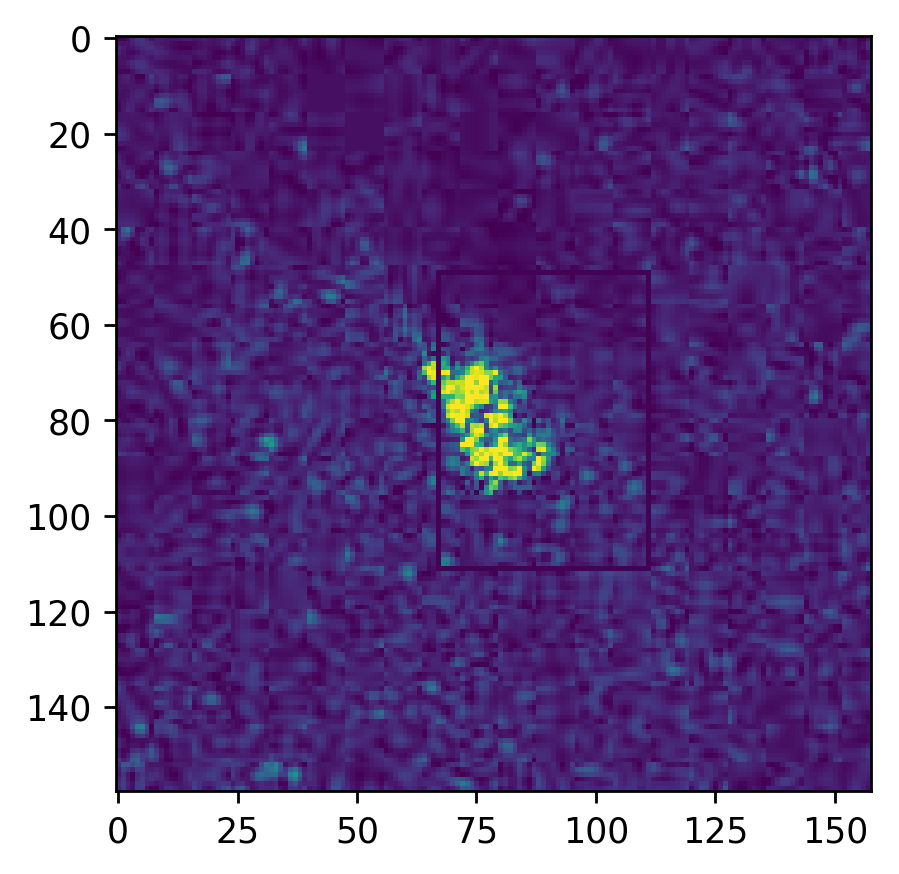

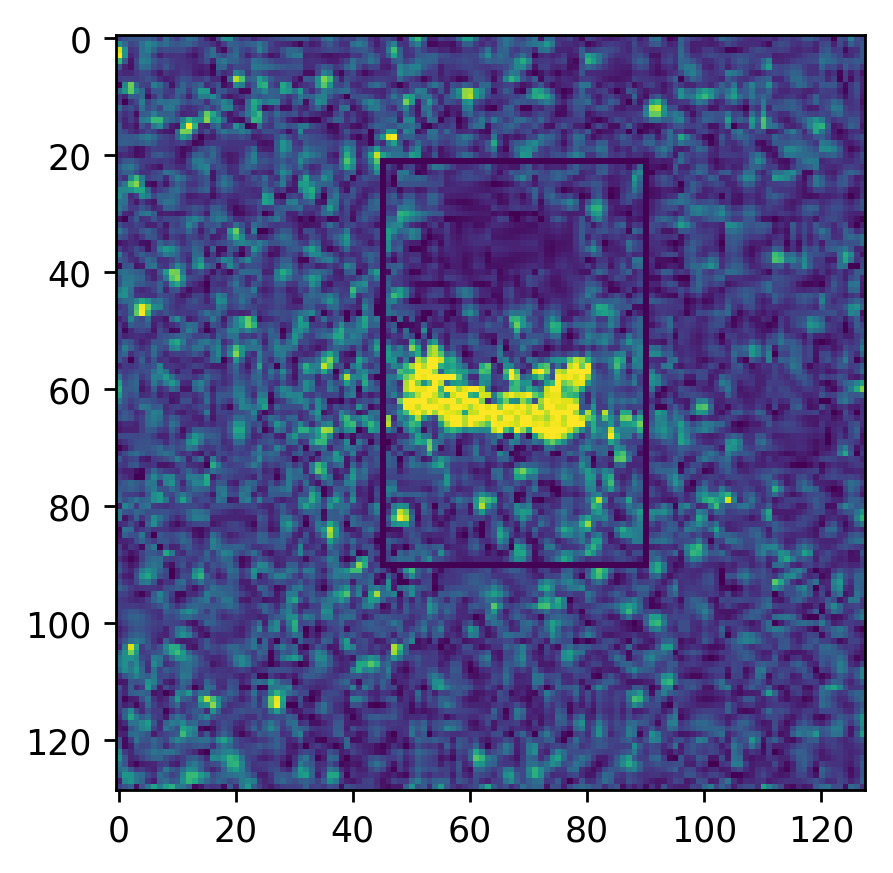

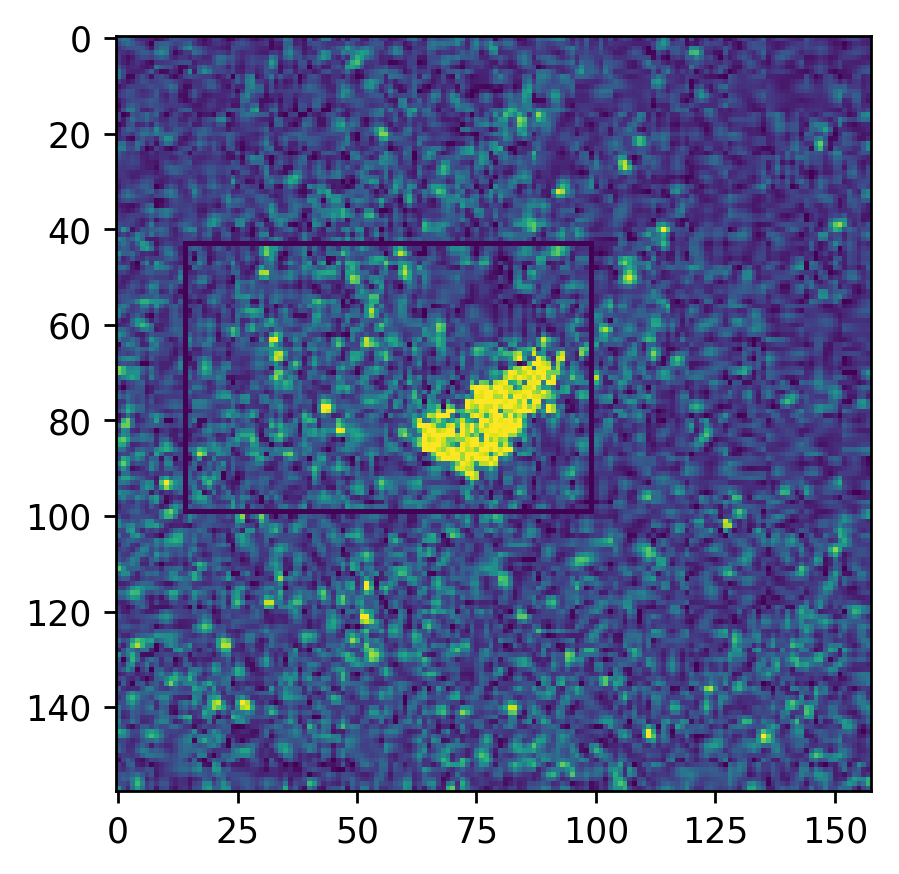

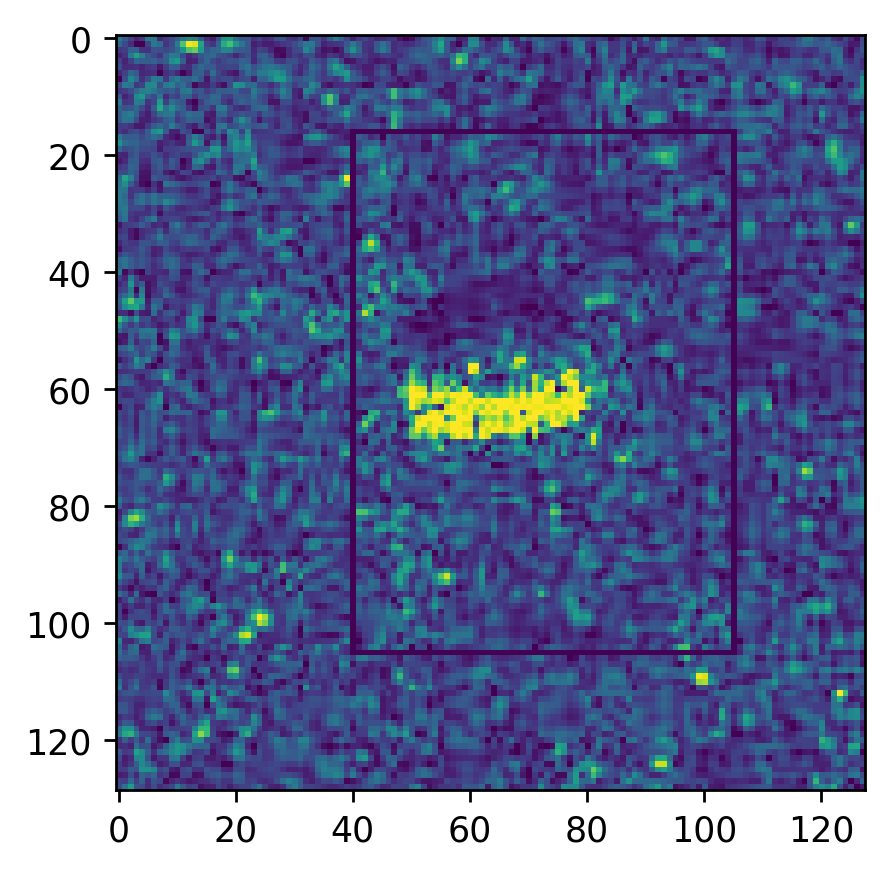

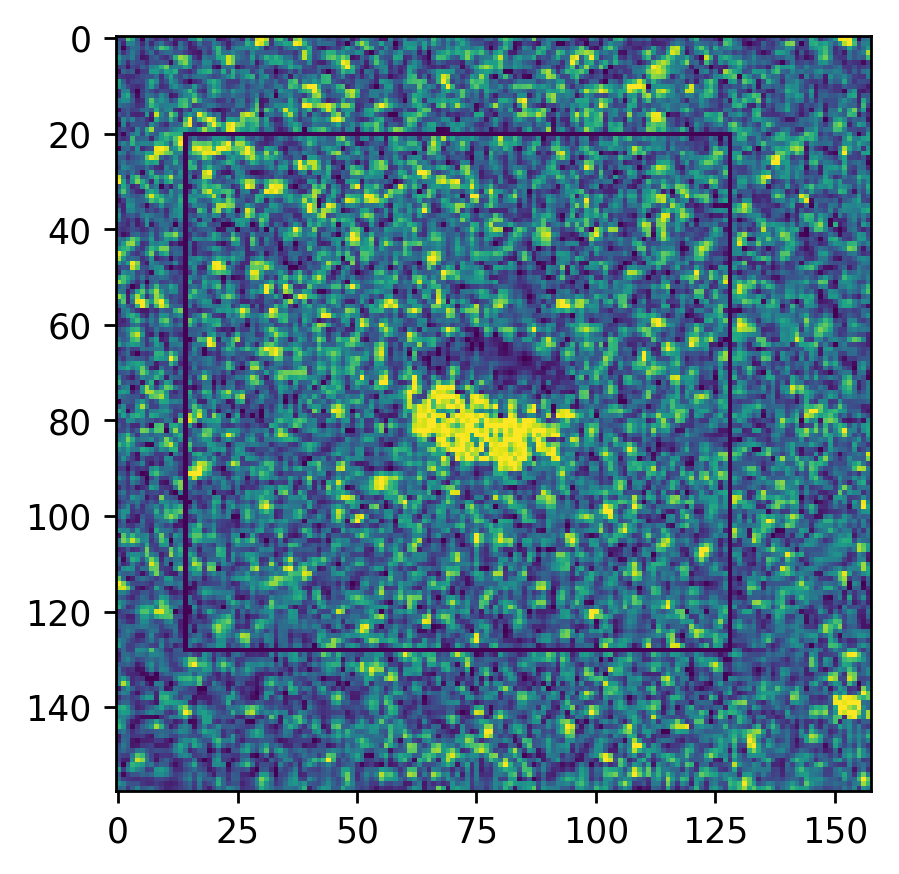

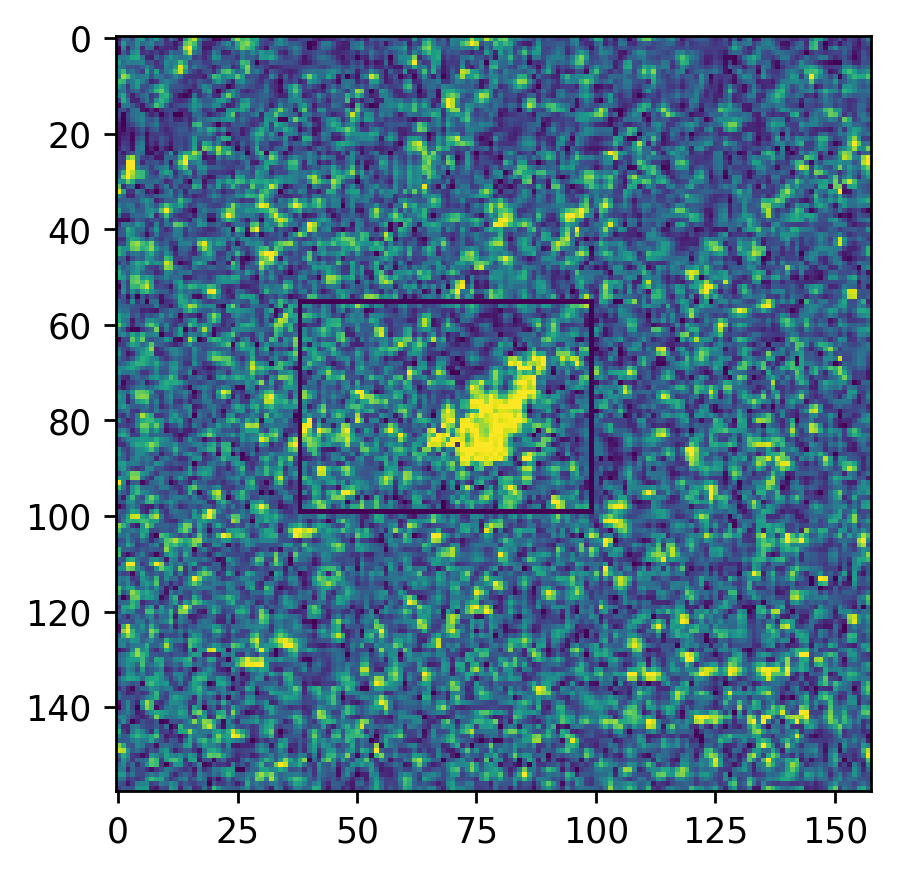

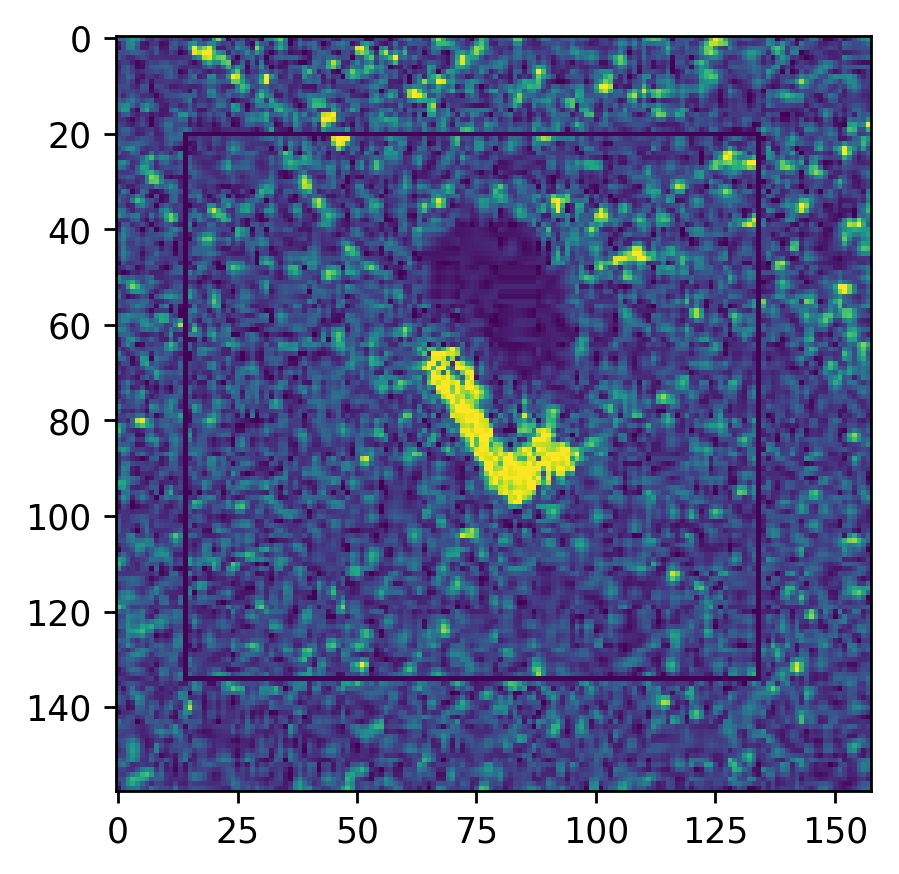

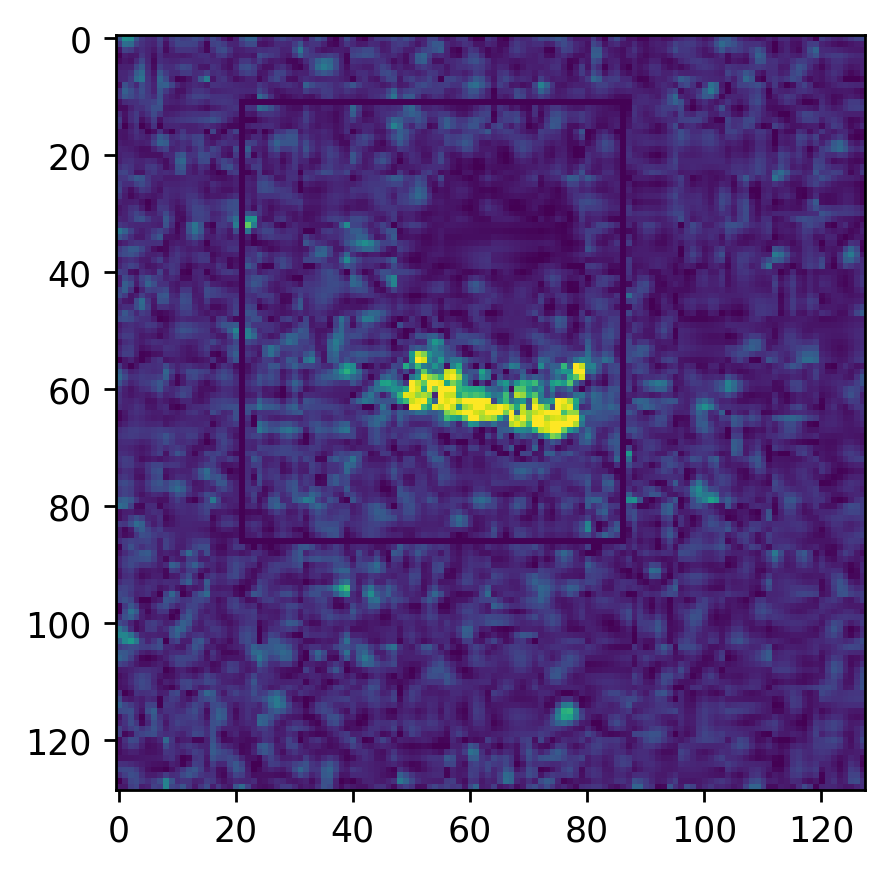

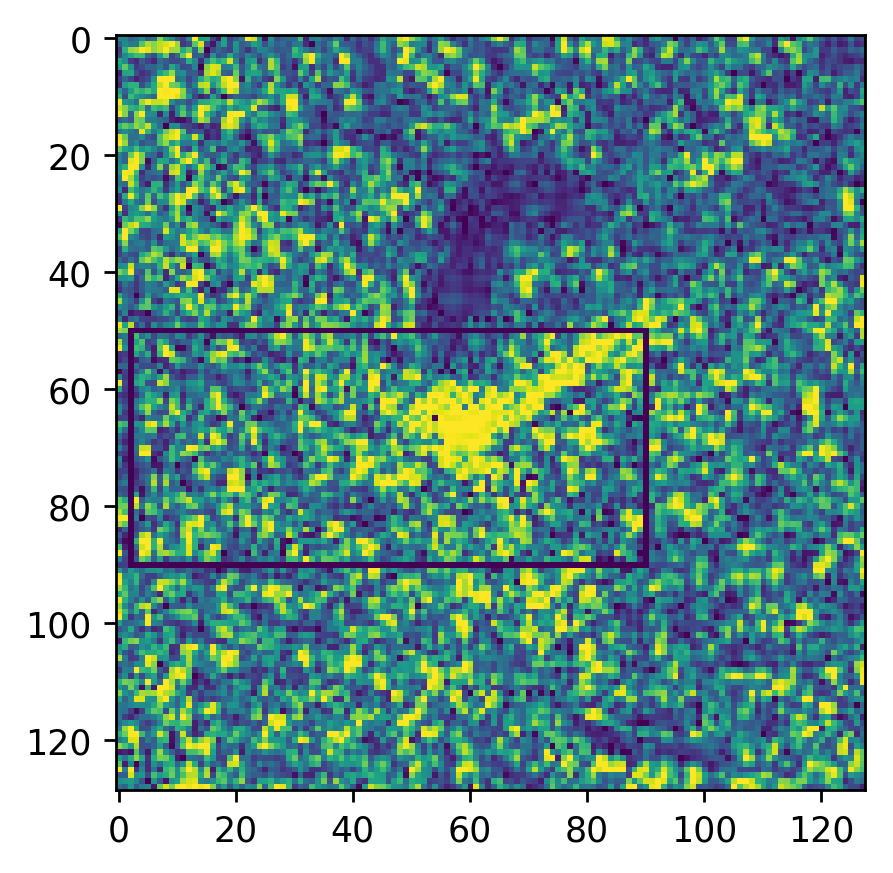

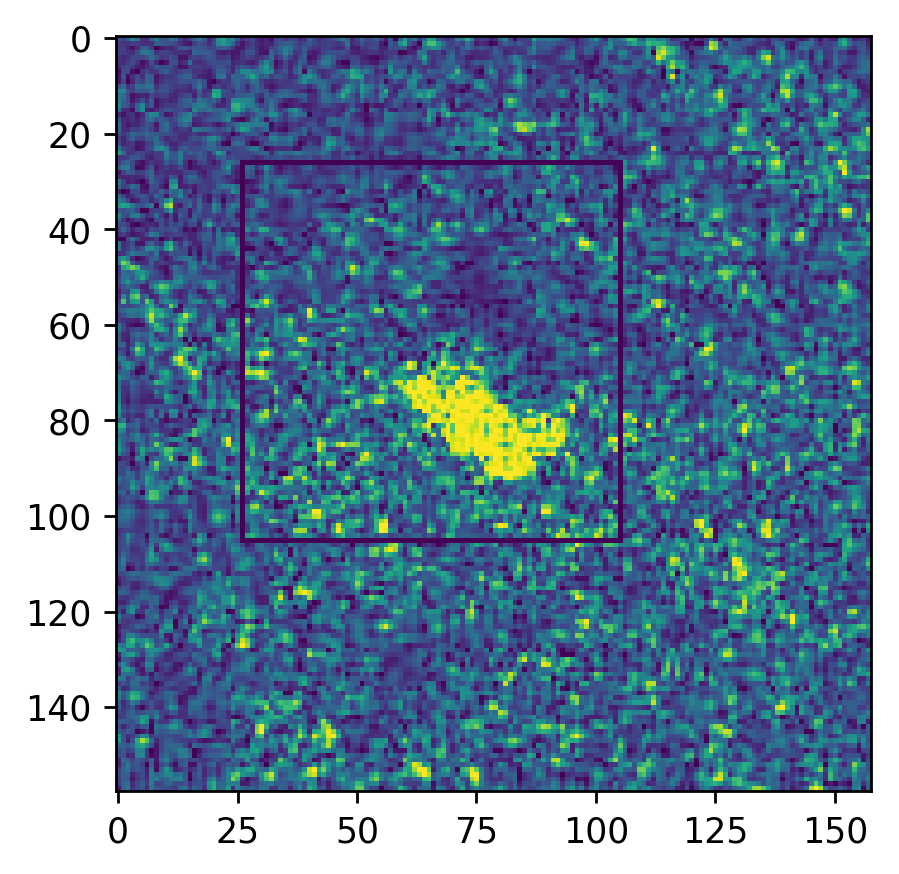

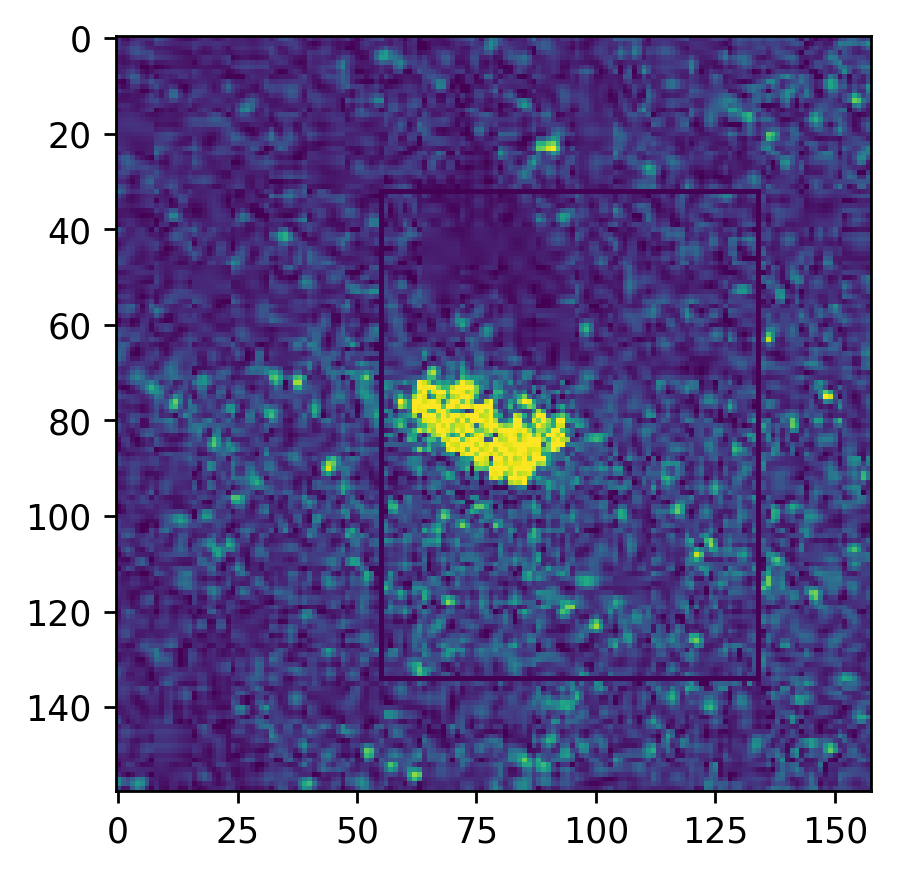

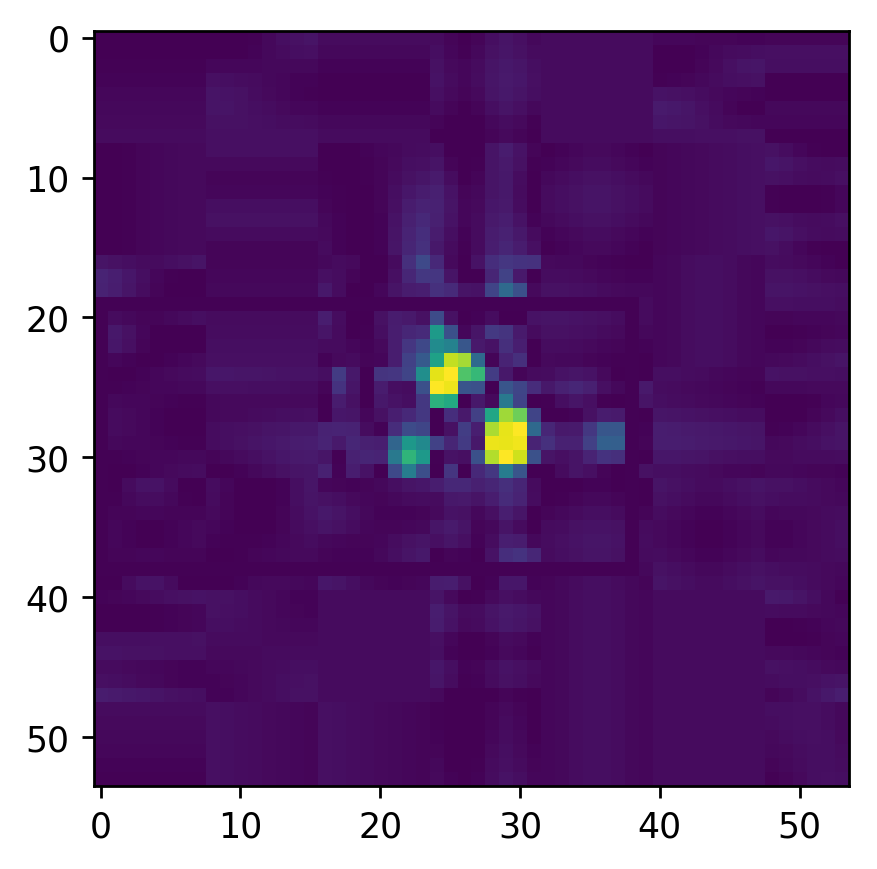

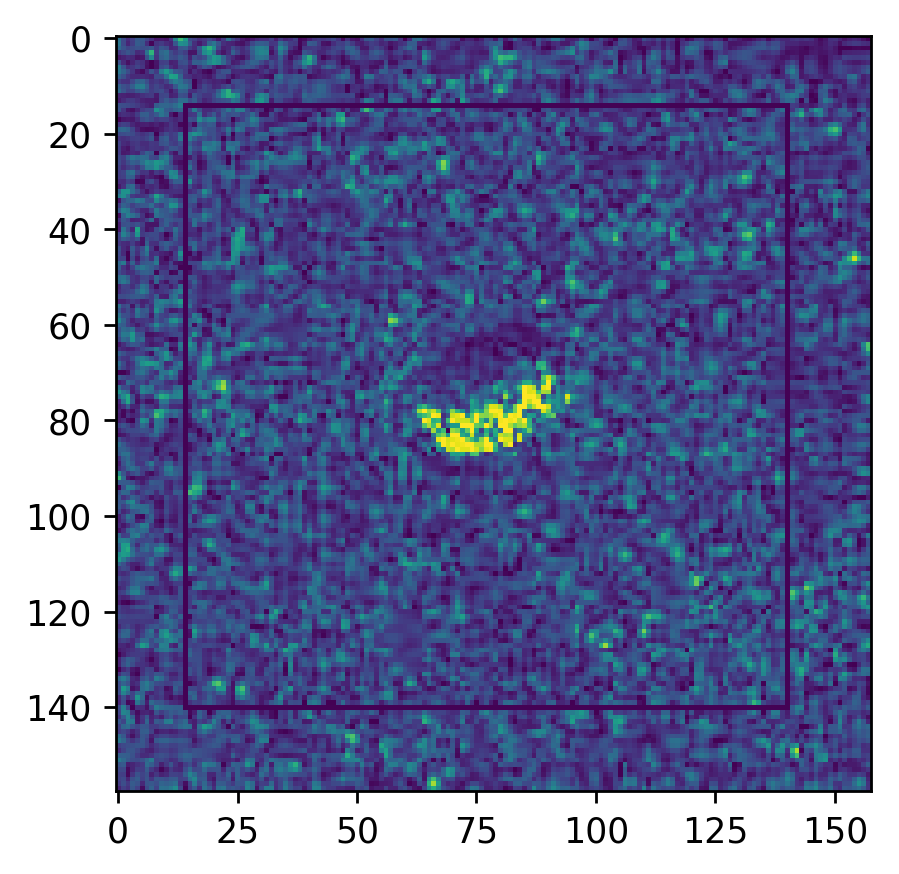

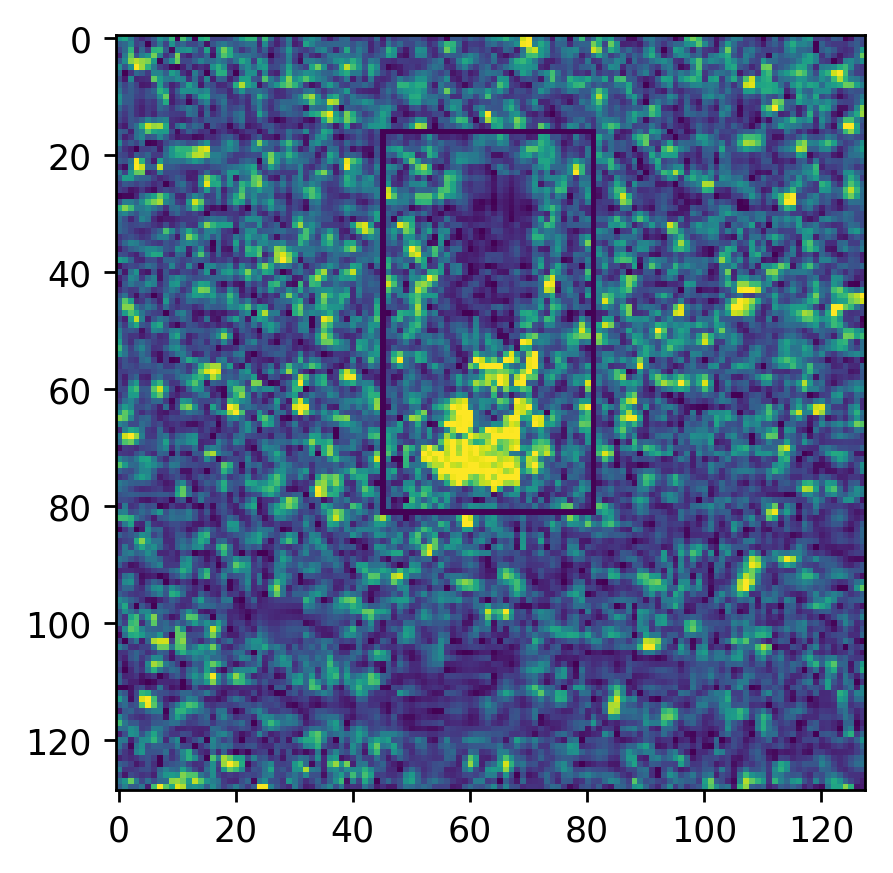

In [23]:
def draw_rect(img, bbox, value=1):
    newimg = img.copy()
    x1, y1, x2, y2 = tuple(bbox.flatten())
    newimg[x1:x2,y1] =  1.0
    newimg[x2,y1:(y2+1)] = 1.0
    newimg[x1:x2,y2] = 1.0
    newimg[x1,y1:y2] = 1.0
    return newimg

test_indices = np.random.randint(0, len(annotations), 30)

for iii in test_indices:
    plt.figure()
    annotation = annotations[iii]
    img = plt.imread(annotation['path'])
    height = int(annotation['height'])
    width =  int(annotation['width'])
    newbox = \
        np.array([int(annotation['tlx']), int(annotation['tly']), int(annotation['brx']), int(annotation['bry'])])
    newbox[newbox<0] = 0
    newbox = newbox * height / 54
    img = draw_rect(img, newbox)
    plt.imshow(img)